# Project: Swedish Municipality KPI Analysis
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se

### Problem Description

* What is the purpose of your study?  

The primary objective of this study is to explore and analyze the impact of higher education on population health in Swedish municipalities. This investigation aims to uncover the nuances of how educational attainment influences various health outcomes and social behaviors within these communities.

Specifically, the study will delve into the following key aspects:
* **The relationship between educational attainment and obesity:** 
Investigating whether lower educational attainment is associated with higher rates of obesity. 
* **The relationship between educational attainment and daily smoking:** 
Investigating the correlation between education levels and smoking habits.
* **The relationship between educational attainment and risky drinking:** 
Analyzing the impact of educational attainment on alcohol consumption patterns.

The study aims to provide insights into the broader significance of educational inconsistencies on public health and social behaviors. The findings are expected to contribute to a deeper understanding of the role of education in shaping health outcomes and social dynamics within Swedish municipalities, potentially informing policy decisions and community health initiatives. 

* Are there errors in the dataset? How did you deal with them? Explain your process and the reasoning behind it. 

* What are the (statistical) data types of the columns in your dataset? 
In our dataset we have a mix of nominal categorical data (`kpi`, `muncipality` and `gender`) and numerical data (`period` and `value`).
1. `kpi` (Key Performance Indicator ID): This column contains alphanumeric codes corresponding to the KPIs analyzed within this dataset. These are nominal data as they are used to identify the KPIs and do not have any inherent order or numerical value.
2. `municipality`: This column contains the names of the municipalities included in the dataset. These are nominal data  as they represent labels or identifiers for different municipalities and do not hold any quantitative value.
3. `period`: This column represents the year and is numerical and is considered as categorical data as it categorizes the data into different years.
4. `gender`: This column contains values K, M and T representing if there is a gender division for the datapoint. K for women, M for men and T for both.
5. `value`: This column contains the values for the KPIs. These are numerical data as they represent the actual values for the KPIs.

* Use a Q-Q plot to compare the distributions of different groups. What you are trying to observe? Why is it is important? Describe the results.

In [256]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

# Load the datasets
kpi_data_path = 'data/kpi_data.csv'
kpi_values_path = 'data/kpi_values.csv'
municipalities_data_path = 'data/municipalities_data.csv'

# Read the data
kpi_data = pd.read_csv(kpi_data_path)
kpi_values = pd.read_csv(kpi_values_path)
municipalities_data = pd.read_csv(municipalities_data_path)

# Displaying the first few rows of each dataset
print(f"{kpi_data.head()}\n")
print(f"{kpi_values.head()}\n")
print(f"{municipalities_data.head()}")

       id                                              title  \
0  N00000  Personalkostnader som andel av verksamhetens k...   
1  N00003                          Personalkostnader, kr/inv   
2  N00005     Utjämningssystemet enl resultaträkning, kr/inv   
3  N00009                   Intäkter kommunen totalt, kr/inv   
4  N00011  Inkomstutjämning, bidrag/avgift, kr/inv. 1 nov...   

                                         description municipality_type  \
0  Personalkostnader kommunen totalt, dividerat m...                 K   
1  Personalkostnader kommunen totalt, dividerat m...                 K   
2  Kommunalekonomisk utjämning kommun, dividerat ...                 K   
3  Externa intäkter exklusive intäkter från försä...                 K   
4  Inkomstutjämning, bidrag/avgift, i kronor per ...                 K   

   is_divided_by_gender  publ_period publication_date  
0                     0          NaN              NaN  
1                     0       2023.0       2024-08-31  
2 

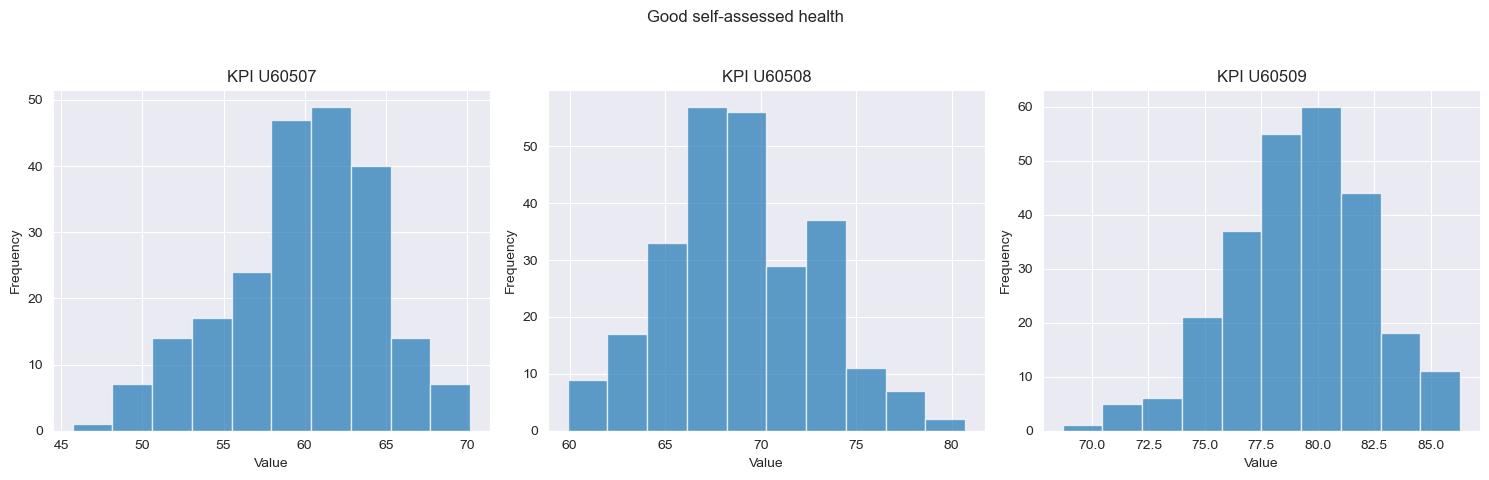

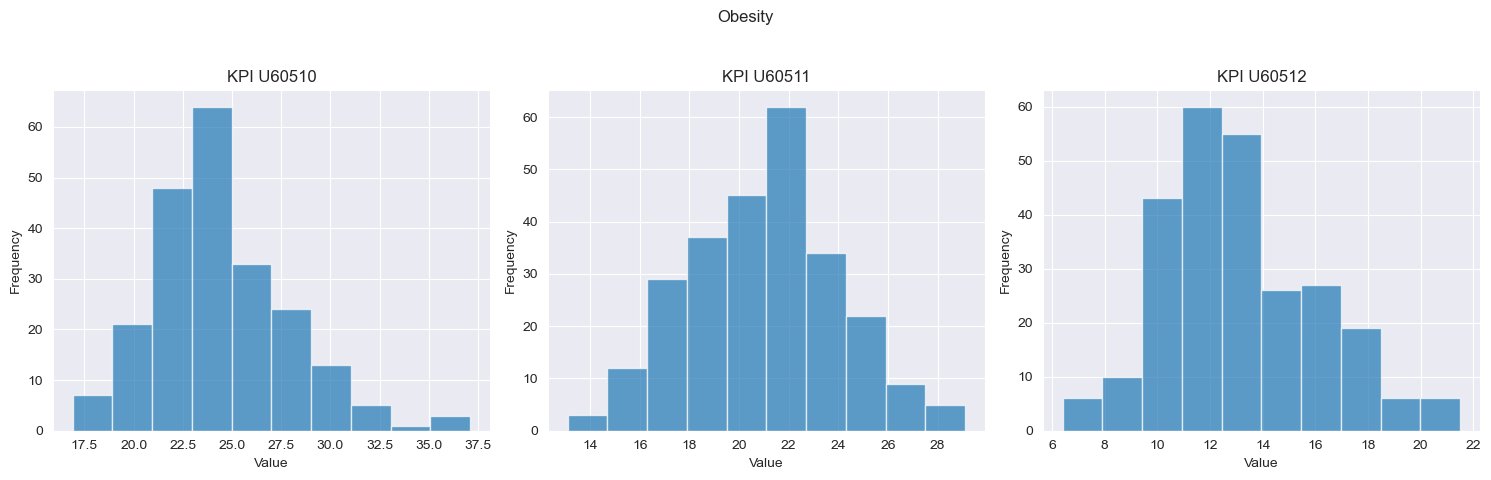

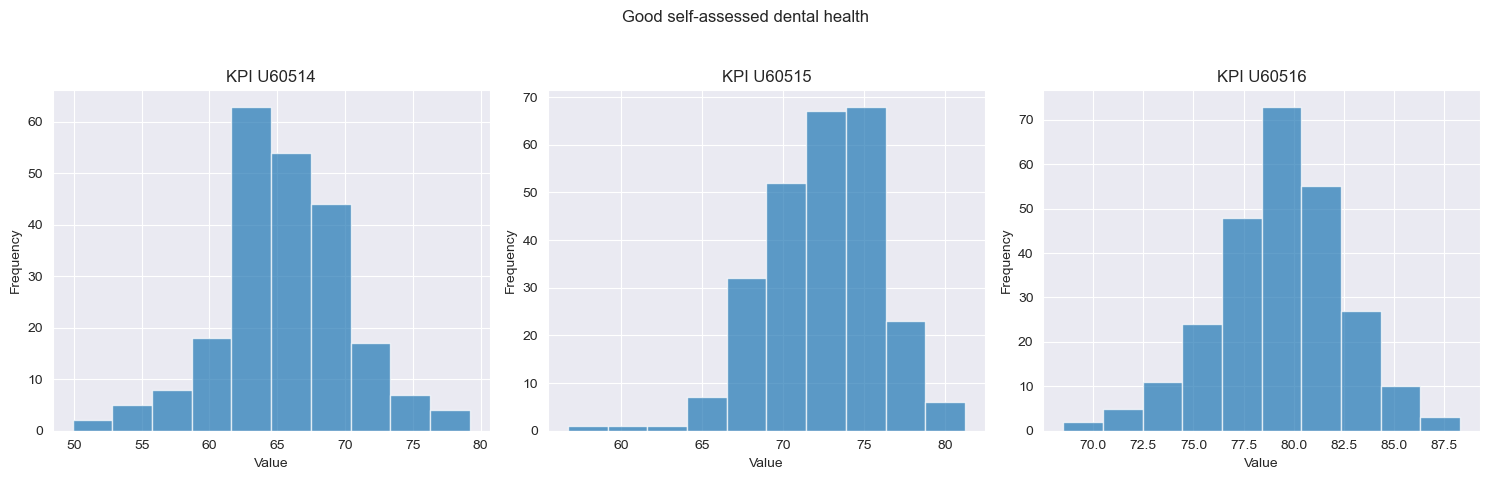

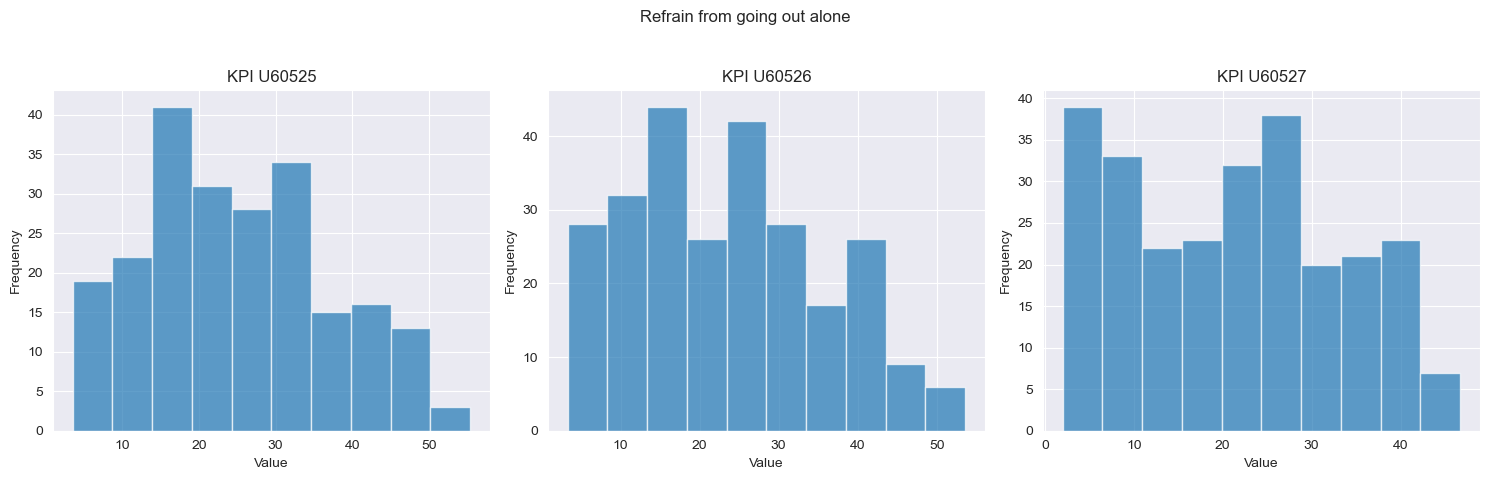

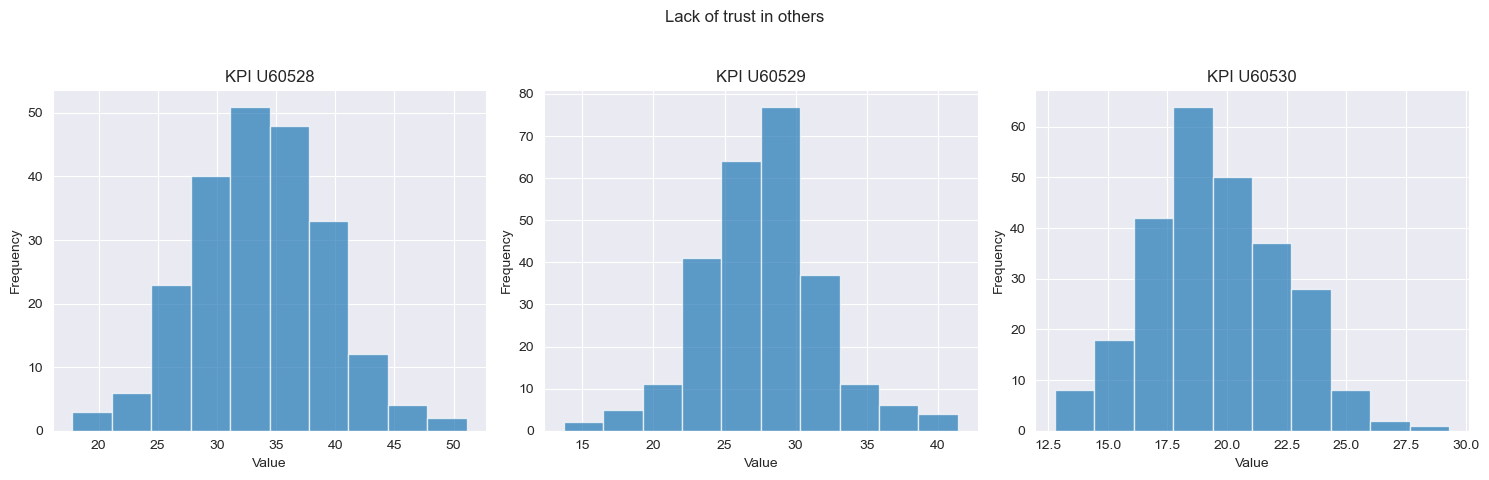

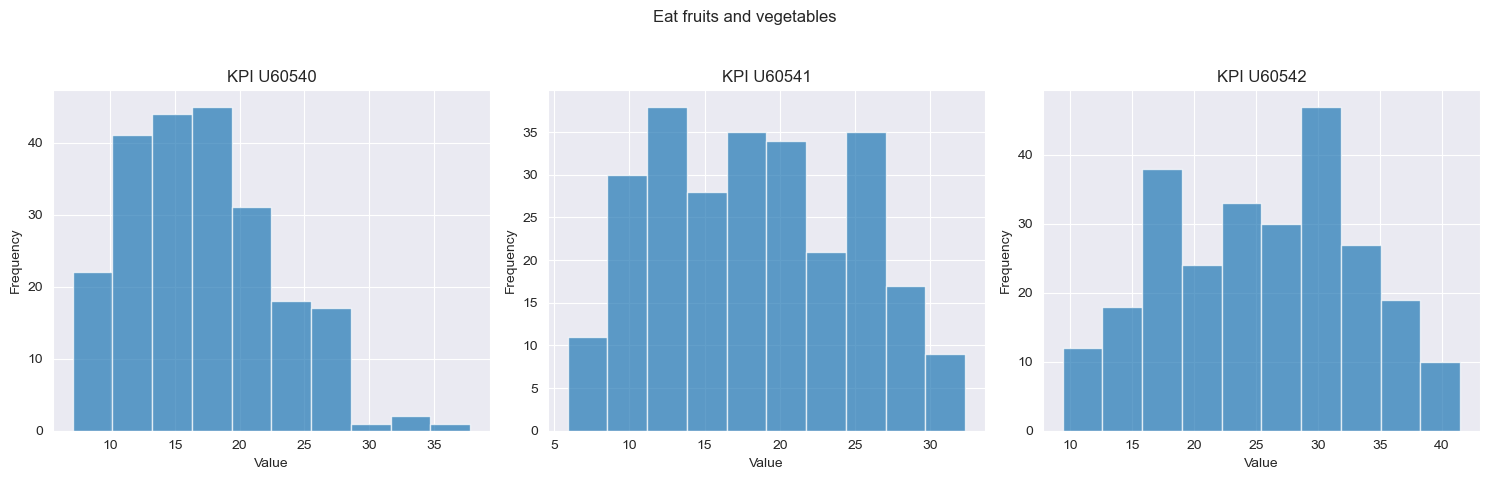

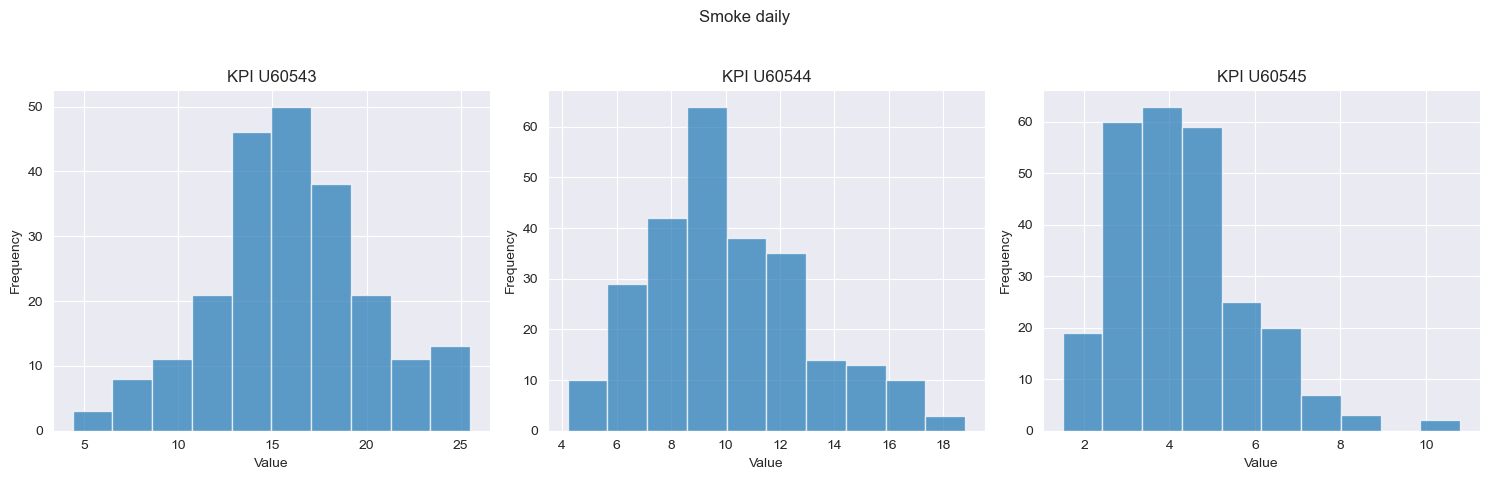

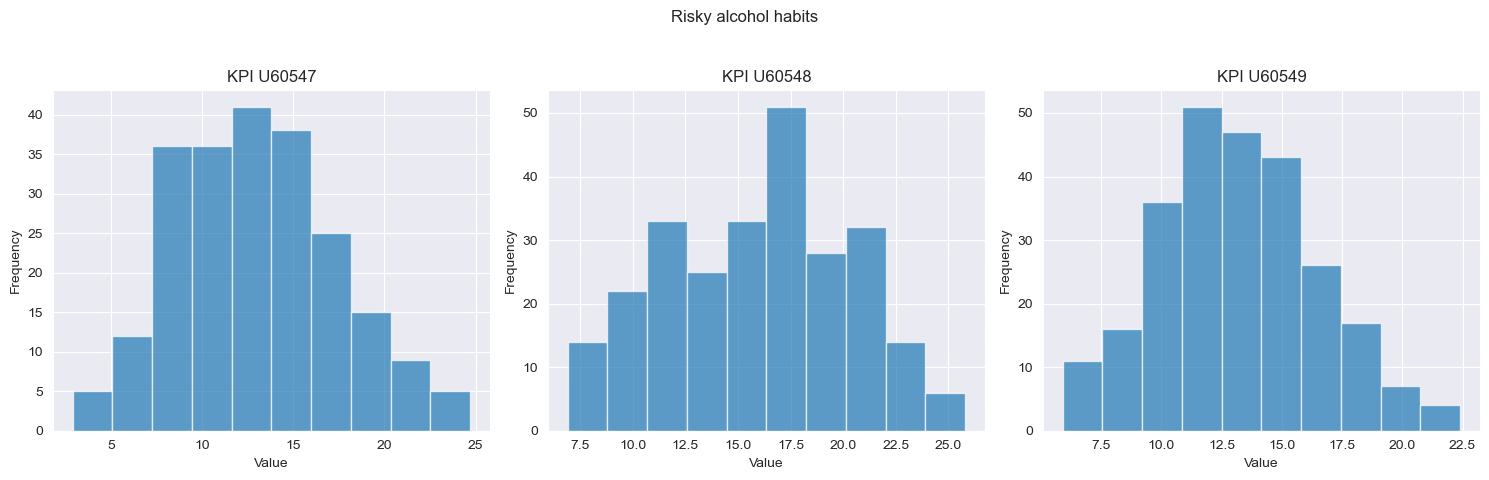

In [257]:
# Analysing the health contributors with different levels of education
# This is done to determine what KPIs are relevant to our analysis
education_health_kpis = [
    'U60507', 'U60508', 'U60509', # Good self-assessed health
    'U60510', 'U60511', 'U60512', # Obesity
    'U60514', 'U60515', 'U60516', # Good self-assessed dental health
    'U60525', 'U60526', 'U60527', # Refrain from going out alone
    'U60528', 'U60529', 'U60530', # Lack of trust in others
    'U60540', 'U60541', 'U60542', # Eat fruits and vegetables
    'U60543', 'U60544', 'U60545', # Smoke daily
    'U60547', 'U60548', 'U60549'  # Risky alcohol habits
]

# Filter the kpi_values dataframe for the KPIs of interest
filtered_df = kpi_values[kpi_values['kpi'].isin(education_health_kpis)]

kpi_groups = {
    'Good self-assessed health': ['U60507', 'U60508', 'U60509'],
    'Obesity': ['U60510', 'U60511', 'U60512'],
    'Good self-assessed dental health': ['U60514', 'U60515', 'U60516'],
    'Refrain from going out alone': ['U60525', 'U60526', 'U60527'],
    'Lack of trust in others': ['U60528', 'U60529', 'U60530'],
    'Eat fruits and vegetables': ['U60540', 'U60541', 'U60542'],
    'Smoke daily': ['U60543', 'U60544', 'U60545'],
    'Risky alcohol habits': ['U60547', 'U60548', 'U60549']
}

# Create subplots for each category
for category, kpis in kpi_groups.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    fig.suptitle(category)

    for i, kpi in enumerate(kpis):
        subset = filtered_df[filtered_df['kpi'] == kpi]
        axes[i].hist(subset['value'], bins=10, alpha=0.7)
        axes[i].set_title(f'KPI {kpi}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [258]:
# List of KPI IDs for each category
health_kpis = ['N00351', 'N00362', 'N00923', 'N00925', 'U01402', 'U01405', 'U01411']
education_kpis = ['N00352', 'N00363']
income_kpis = ['N00348', 'N00359', 'N00349', 'N00360', 'N00906', 'N00907']

# Filtering the kpi_values dataframe to create separate dataframes for each category
health_df = kpi_values[kpi_values['kpi'].isin(health_kpis)]
education_df = kpi_values[kpi_values['kpi'].isin(education_kpis)]
income_df = kpi_values[kpi_values['kpi'].isin(income_kpis)]

# Display the first few rows of each filtered dataframe to verify
print(f"{health_df.head()}\n")
print(f"{education_df.head()}\n")
print(f"{income_df.head()}\n")

         kpi  municipality  period gender      value
3182  N00351             0    2022      T  63.598955
3183  N00351             1    2022      T  82.754882
3184  N00351             3    2022      T  68.787137
3185  N00351             4    2022      T  36.220026
3186  N00351             5    2022      T  69.022839

         kpi  municipality  period gender      value
3204  N00352             0    2022      T  55.581171
3205  N00352             1    2022      T  56.368334
3206  N00352             3    2022      T  58.781354
3207  N00352             4    2022      T  48.612333
3208  N00352             5    2022      T  55.041985

         kpi  municipality  period gender      value
3116  N00348             0    2022      T  23.053445
3117  N00348             1    2022      T  48.697470
3118  N00348             3    2022      T  22.569836
3119  N00348             4    2022      T   3.667282
3120  N00348             5    2022      T  21.125893


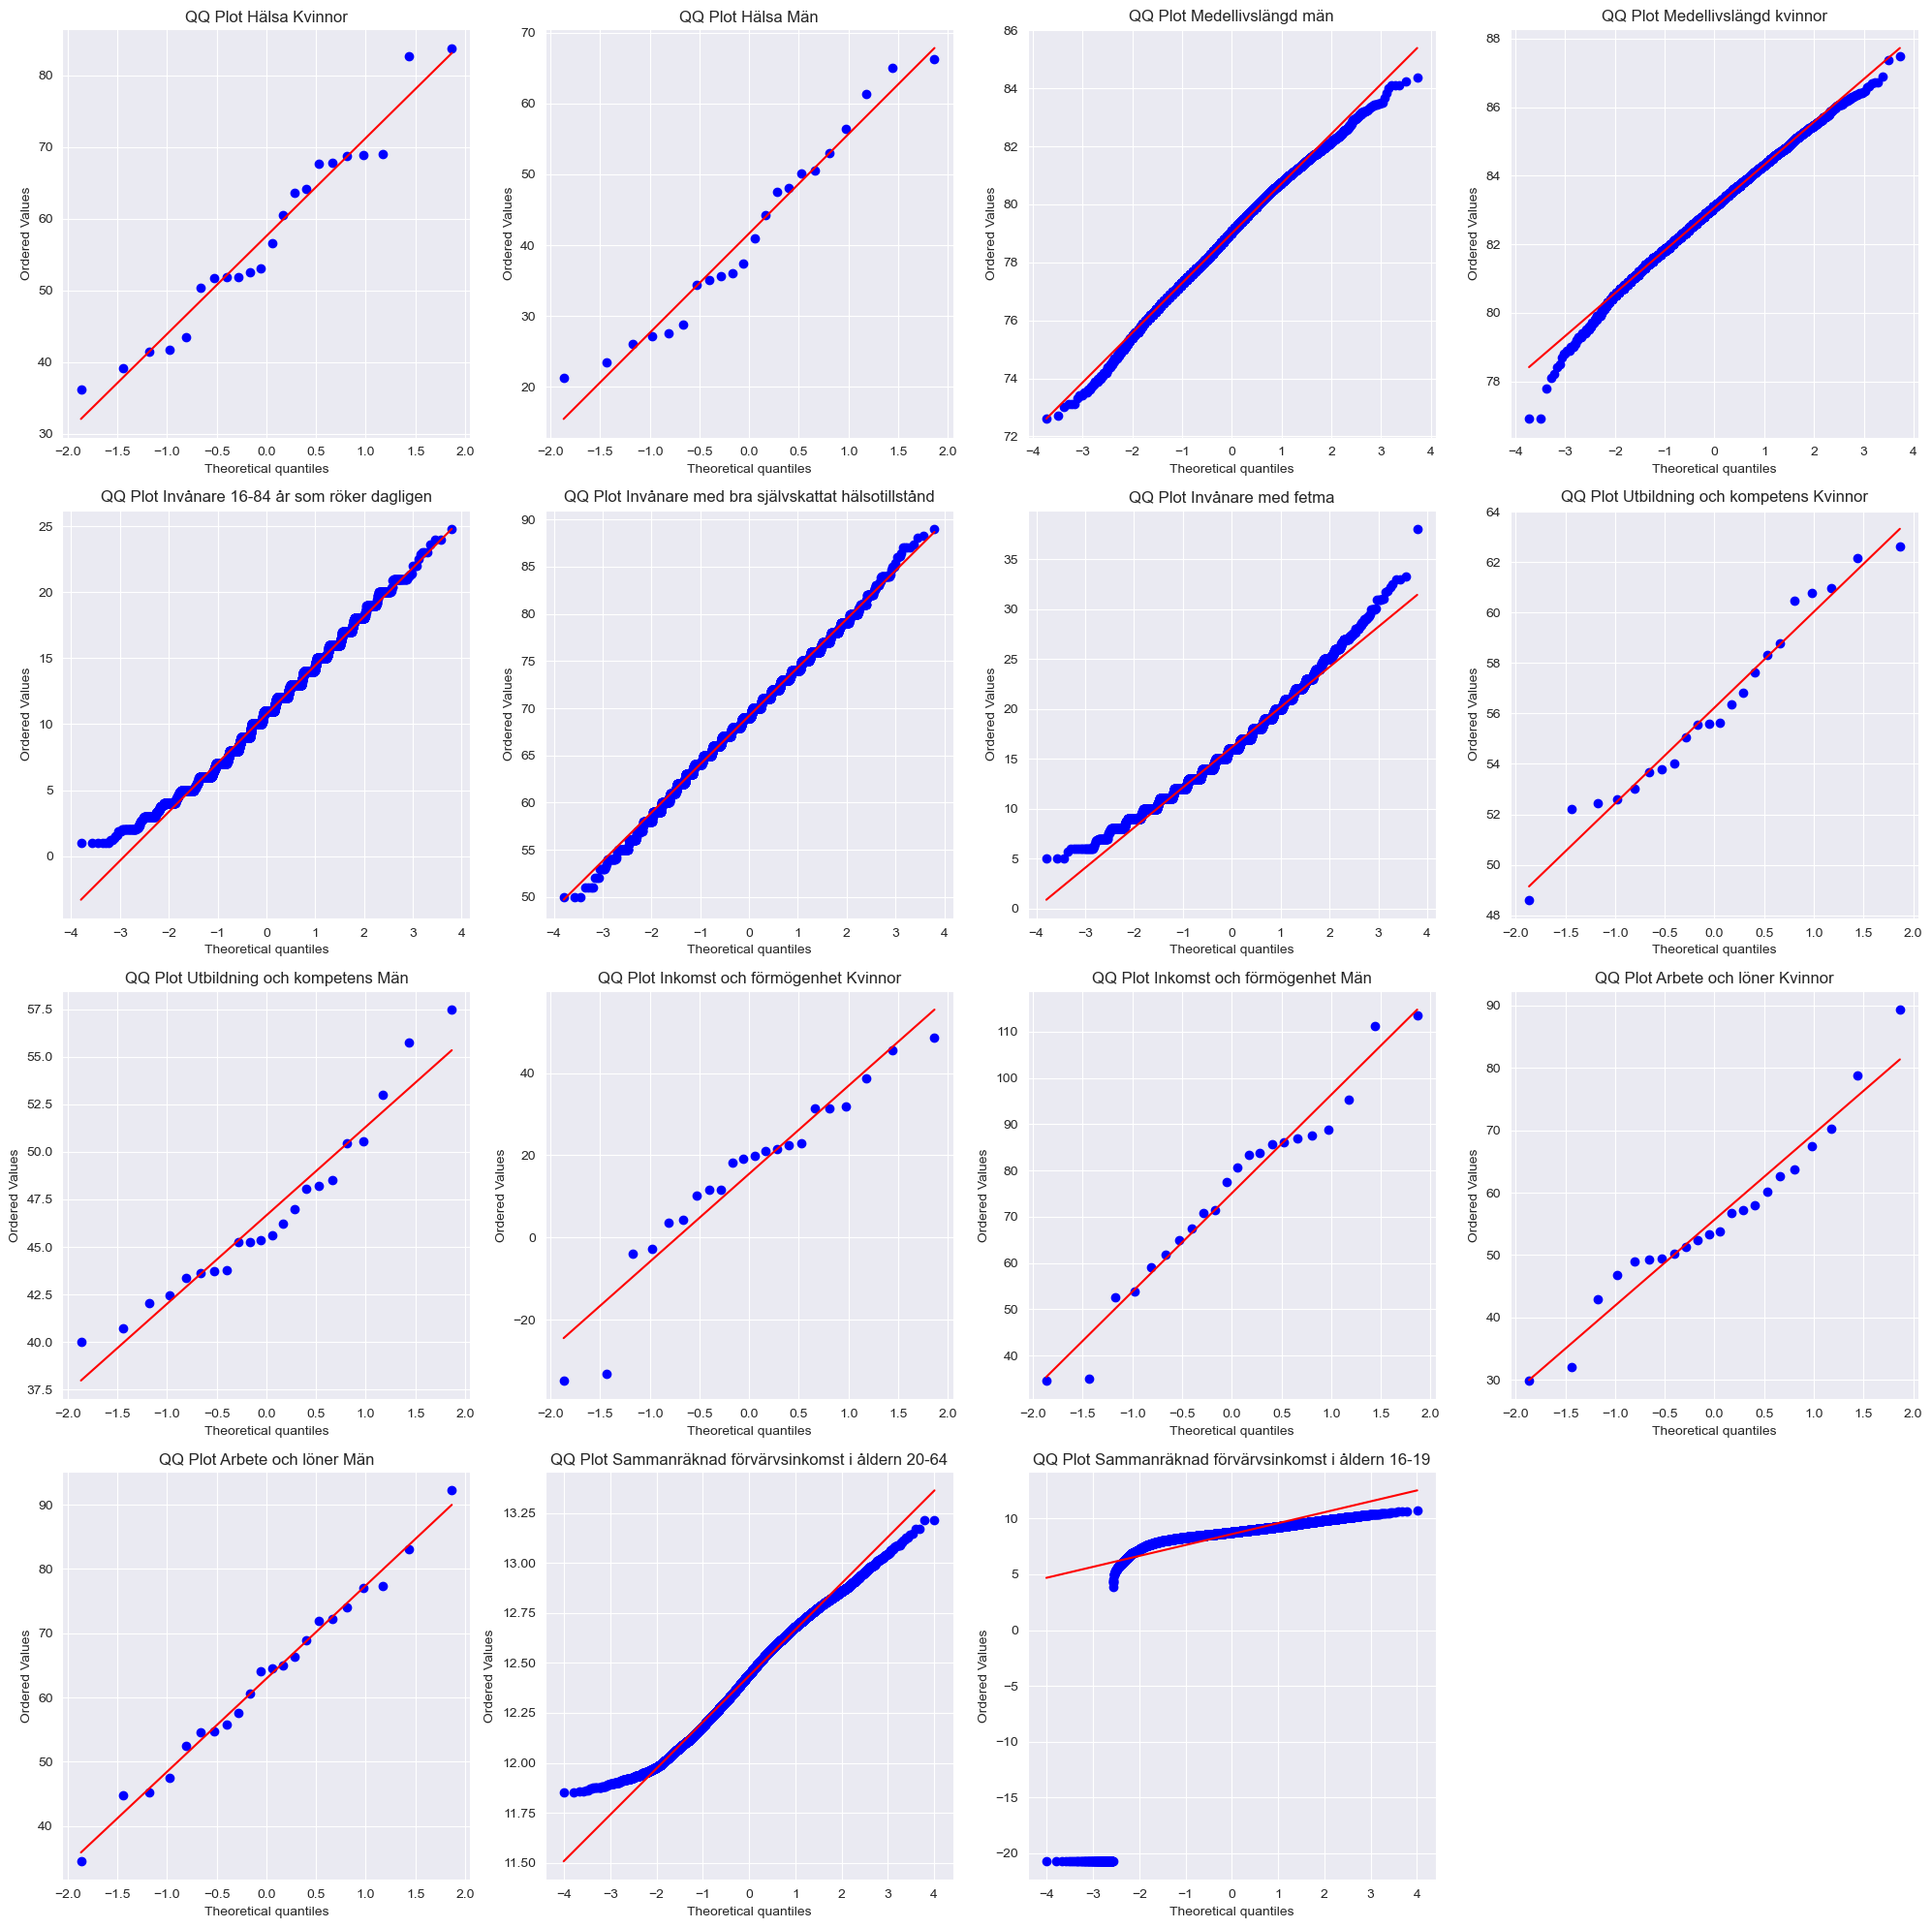

In [259]:
# Define which KPIs should be log-transformed
log_transform_kpis = ['N00906', 'N00907']

# Combine all the KPIs into a single dataframe
all_kpis_df = pd.concat([health_df, education_df, income_df])

# Combine all the lists to create a master list of KPIs
all_kpis = health_kpis + education_kpis + income_kpis

def create_qq_plots_for_kpis(kpi_list, df):
    # Define the number of rows and columns for the subplot grid
    num_plots = len(kpi_list)
    cols = 4  # We choose 4 columns for our grid
    rows = num_plots // cols + (num_plots % cols > 0)  # This ensures we have enough rows for all KPIs

    # Create the subplots with the desired number of rows and columns
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Flatten the Axes array if there are multiple rows
    if num_plots > cols:
        axs = axs.flatten()

    for i, kpi in enumerate(kpi_list):
        # Filter for the KPI and total population
        data = df[df['kpi'] == kpi]['value']

        # Check if log transformation is needed
        if kpi in log_transform_kpis:
            # Apply log transformation, avoiding log(0) by adding a small constant
            data = np.log(data + 1e-9)

        # Generate QQ plot
        stats.probplot(data, dist="norm", plot=axs[i])
        kpi_title = kpi_names.get(kpi, kpi)
        axs[i].set_title(f'QQ Plot {kpi_title.replace(", år", "").replace("Regionindex", "").replace(" – ", "").replace(", andel (%)", "").replace(" år (median), kr", "")}')

    # Hide any unused subplots
    for i in range(num_plots, rows * cols):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

# Generate QQ plots for all KPIs
create_qq_plots_for_kpis(all_kpis, all_kpis_df)

 ### Exploratory Data Analysis

* Show the histogram of some selected KPIs and describe your observation.
* Show the dependence of some selected variables and describe your observation.
* Describe the data using its range, sample mean, sample standard deviation and some quantiles. Describe your observation.
* Choose another visualization method to explore the data set.
* Draw conclusion from your exploratory analysis

### Descriptive Statistics

In [260]:
# Determine the number of unique KPIs in each category
unique_kpis = all_kpis_df['kpi'].unique()

# Calculate descriptive statistics for each unique KPI
descriptive_stats = {kpi_names[kpi]: all_kpis_df[all_kpis_df['kpi'] == kpi]['value'].describe()
                     for kpi in unique_kpis}

# Create a formatted string for better readability
formatted_stats = ""
for kpi, stats in descriptive_stats.items():
    formatted_stats += f"Descriptive statistics for {kpi}:\n{stats}\n\n"

# Print the formatted descriptive statistics
print(formatted_stats)

Descriptive statistics for Hälsa – Regionindex Kvinnor:
count    22.000000
mean     57.605826
std      13.277871
min      36.220026
25%      50.773805
50%      54.849984
75%      67.735886
max      83.833148
Name: value, dtype: float64

Descriptive statistics for Hälsa – Regionindex Män:
count    22.000000
mean     41.654250
std      13.576229
min      21.252717
25%      30.145915
50%      39.170170
75%      50.404391
max      66.242924
Name: value, dtype: float64

Descriptive statistics for Medellivslängd män, år:
count    7158.000000
mean       78.999892
std         1.716899
min        72.600000
25%        77.800000
50%        79.075000
75%        80.230000
max        84.370000
Name: value, dtype: float64

Descriptive statistics for Medellivslängd kvinnor, år:
count    7158.000000
mean       83.067685
std         1.250349
min        76.900000
25%        82.200000
50%        83.100000
75%        83.920000
max        87.480000
Name: value, dtype: float64

Descriptive statistics for Inv

### Histograms

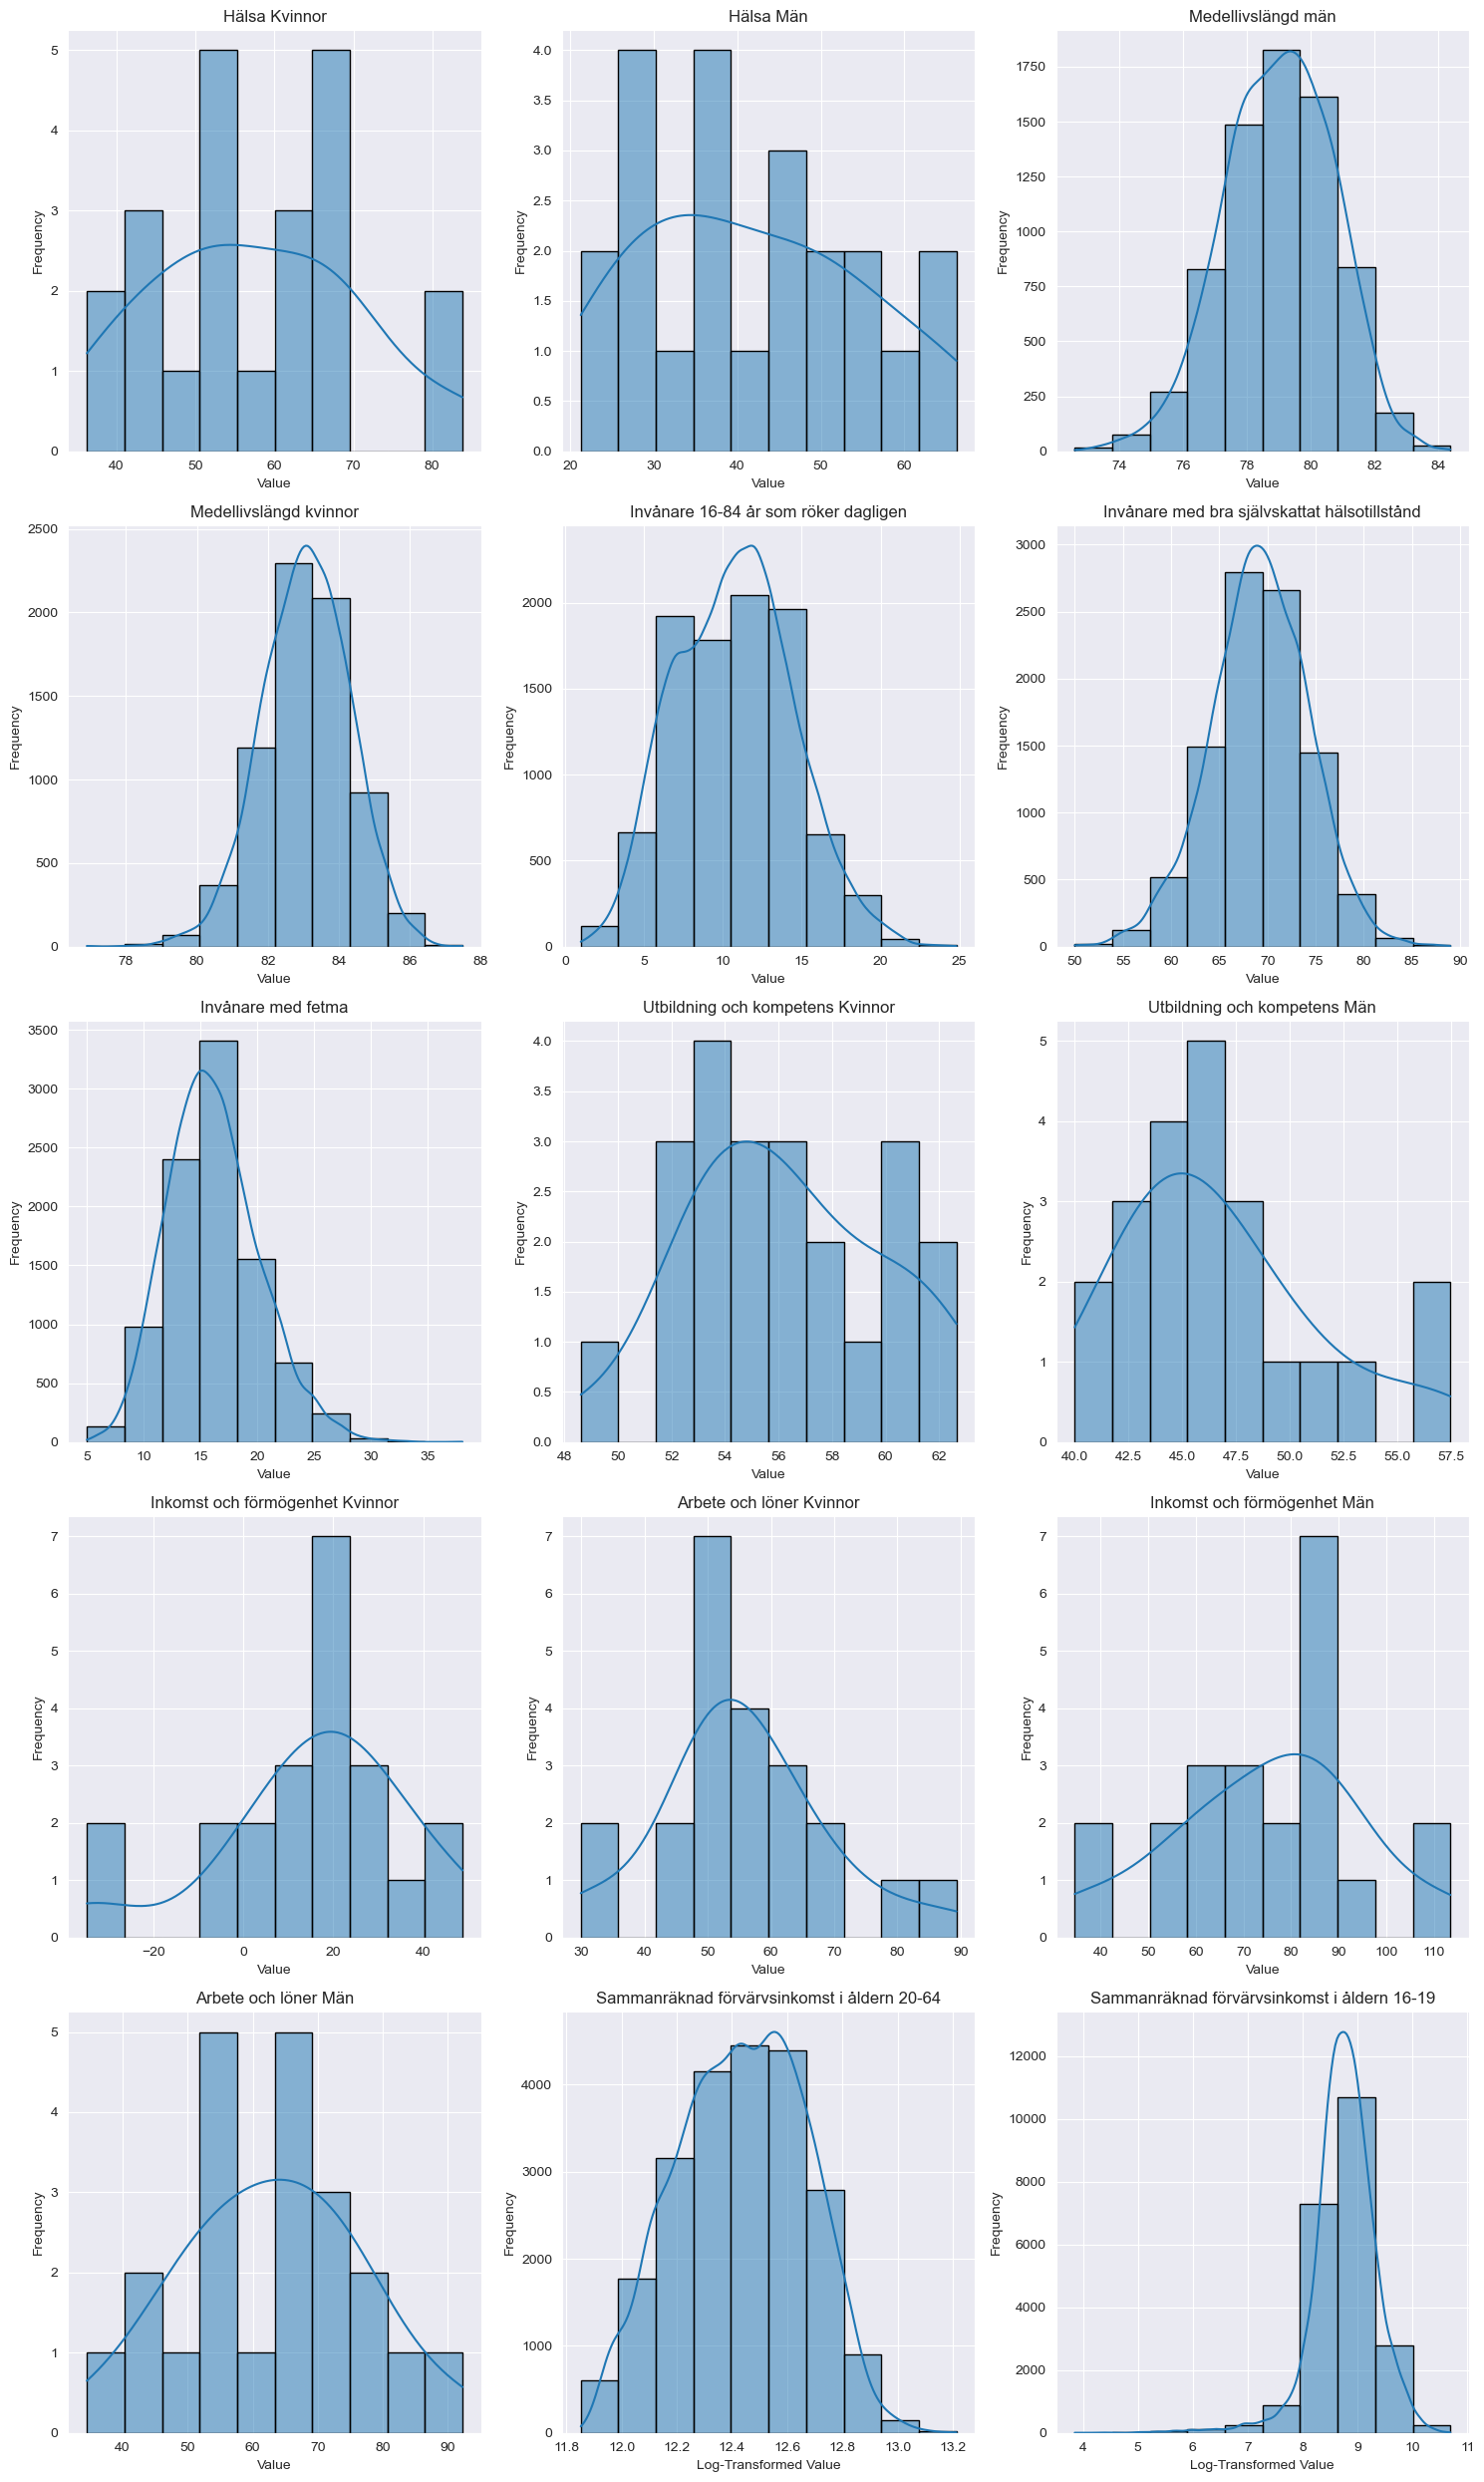

In [261]:
def plot_kpi_histograms(df, kpi_names, raw_income_kpis, num_bins=10, num_cols=3):
    # Extract unique KPIs from the DataFrame
    unique_kpis = df['kpi'].unique()

    # Adjust the size of the plot based on the number of unique KPIs
    num_rows = len(unique_kpis) // num_cols + (len(unique_kpis) % num_cols > 0)  # Calculate the number of rows needed
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust the size dynamically

    # Check if axs is an array of axes, if not, wrap it in an array for consistency
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Flatten the Axes array for easy iteration
    axs = axs.flatten()

    # Plot a histogram for each KPI
    for i, kpi in enumerate(unique_kpis):
        # Select the data for the current KPI
        data = df[df['kpi'] == kpi]['value']

        # If the current KPI is in the list of income KPIs, apply a log transform to positive values only
        if kpi in raw_income_kpis:
            data = data[data > 0]  # Filter out non-positive values
            data = np.log(data)  # Apply log transformation
            axs[i].set_xlabel('Log-Transformed Value')
        else:
            axs[i].set_xlabel('Value')

        # Plot the histogram using seaborn
        sns.histplot(data, bins=num_bins, ax=axs[i], kde=True, edgecolor='black')

        # Map the kpi to its name for the title
        kpi_name = kpi_names.get(kpi, kpi)
        axs[i].set_title(f'{kpi_name.replace(", år", "").replace("Regionindex", "").replace(" – ", "").replace(", andel (%)", "").replace(" år (median), kr", "")}')
        axs[i].set_ylabel('Frequency')

    # Hide any unused axes if the number of KPIs doesn't fill the grid
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

raw_income_kpis = ['N00906', 'N00907']  # List of raw income KPI IDs
plot_kpi_histograms(all_kpis_df, kpi_names, raw_income_kpis)

### Histogram: Observations

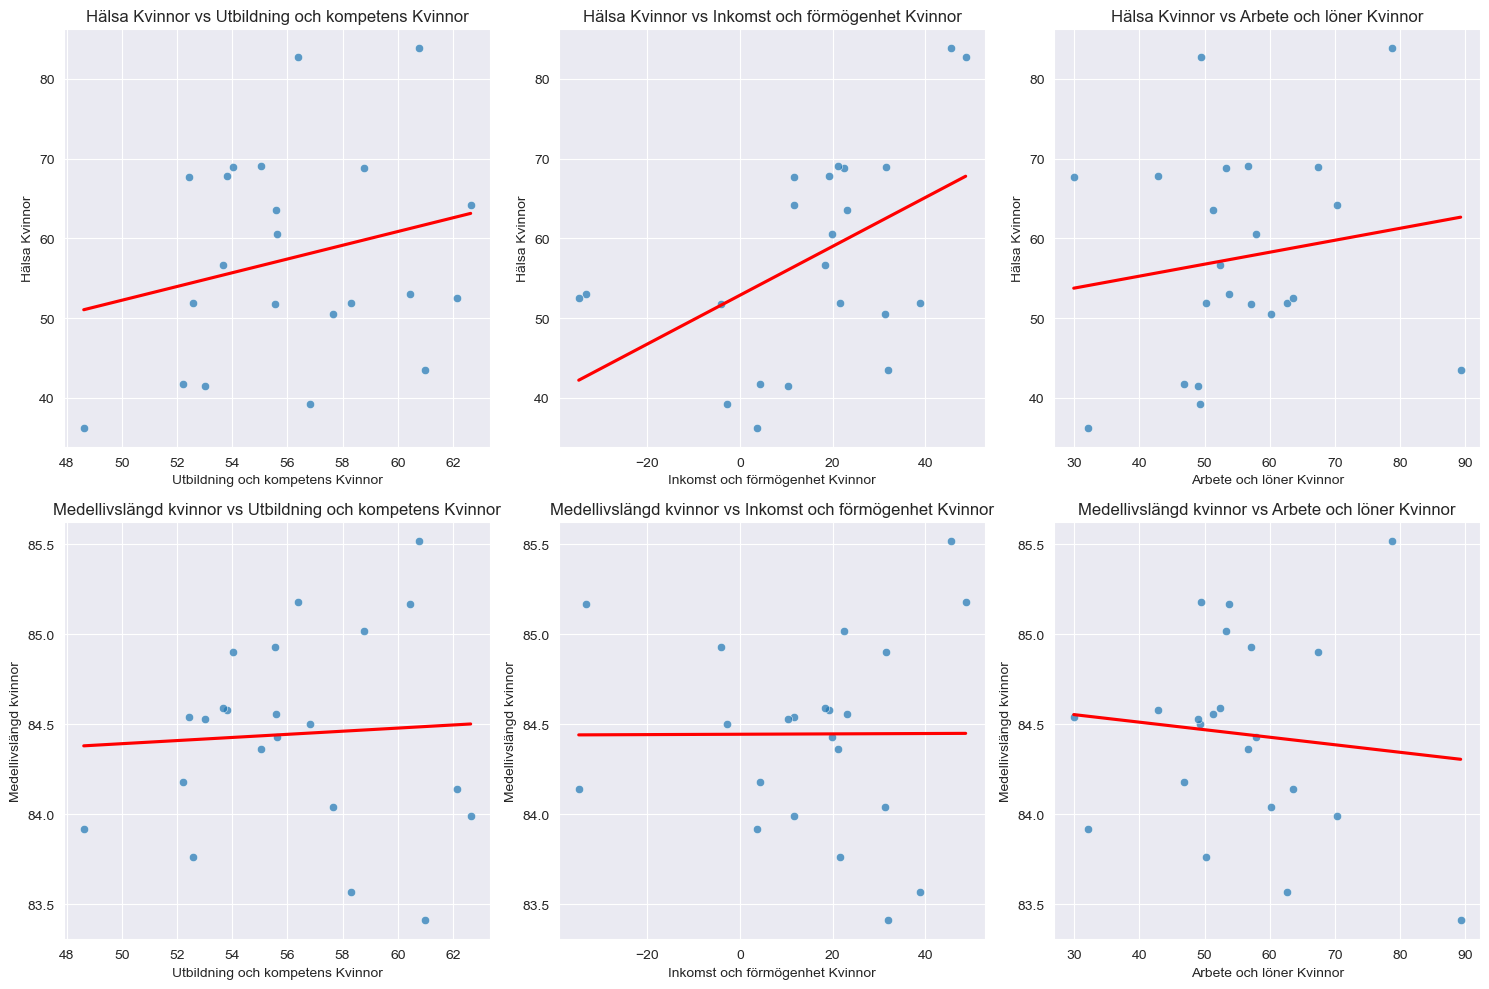

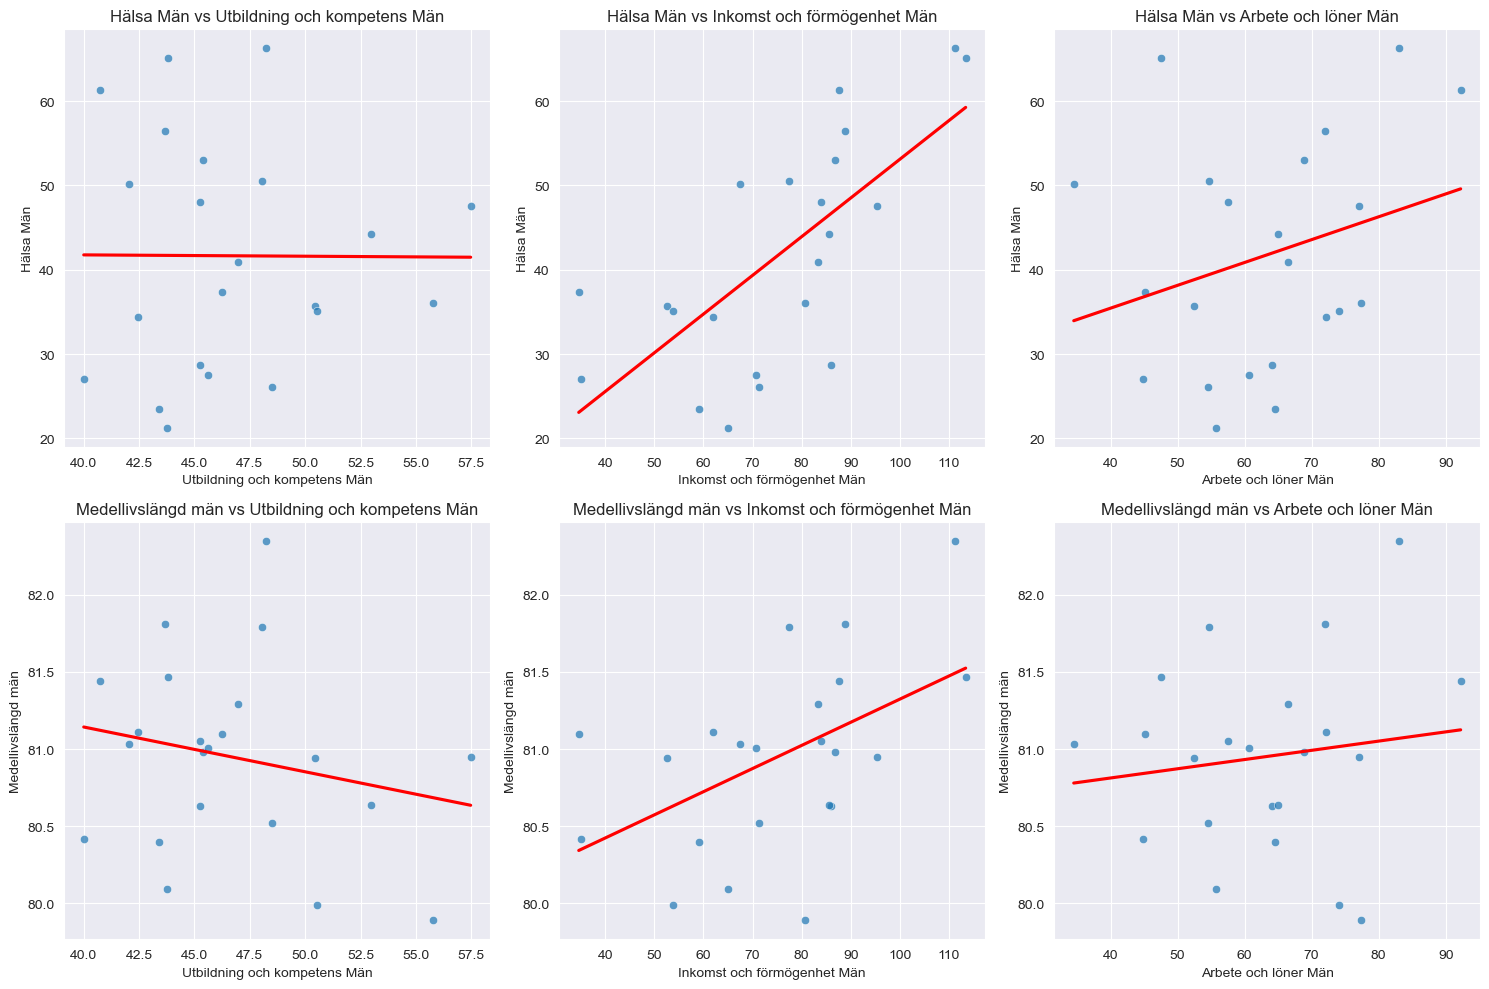

In [262]:
# Filter the DataFrame to only include data from the year 2022
df_2022 = all_kpis_df[all_kpis_df['period'] == 2022]

# Define dependent and independent variables for women
dependent_vars_women = ['N00351', 'N00925']  # Women's health and life expectancy
independent_vars_women = ['N00352', 'N00348', 'N00349']  # Women's education, income, work and wages

# Define dependent and independent variables for men
dependent_vars_men = ['N00362', 'N00923']  # Men's health and life expectancy
independent_vars_men = ['N00363', 'N00359', 'N00360']  # Men's education, income, work and wages

# Function to create scatter plots with trend lines for a given gender
def create_scatter_plots(df, dependent_vars, independent_vars, kpi_names):
    # Calculate the total number of plots
    total_plots = len(dependent_vars) * len(independent_vars)

    # Define the number of columns
    cols = 3

    # Calculate the number of rows needed
    rows = total_plots // cols + (total_plots % cols > 0)

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    # Plot counter
    plot_count = 0

    for dep_var in dependent_vars:
        for ind_var in independent_vars:
            # Merge the data on 'municipality' for the specific KPIs
            dep_data = df[df['kpi'] == dep_var]
            ind_data = df[df['kpi'] == ind_var]
            merged_data = pd.merge(dep_data, ind_data, on='municipality', suffixes=('_dep', '_ind'))

            # Look up the KPI names using the kpi_names dictionary
            dep_var_name = kpi_names[dep_var] if dep_var in kpi_names else dep_var
            ind_var_name = kpi_names[ind_var] if ind_var in kpi_names else ind_var

            # Remove 'Regionindex' from the names and split at '–' and remove ', år'
            dep_var_name = ' '.join([part.strip() for part in dep_var_name.replace('Regionindex', '').split('–')]).replace(', år', '').strip()
            ind_var_name = ' '.join([part.strip() for part in ind_var_name.replace('Regionindex', '').split('–')]).replace(', år', '').strip()

            # Create the scatter plot on the appropriate subplot
            sns.scatterplot(x=merged_data['value_ind'], y=merged_data['value_dep'], alpha=0.7, ax=axs[plot_count])
            sns.regplot(x=merged_data['value_ind'], y=merged_data['value_dep'], scatter=False, ci=None, color='red', ax=axs[plot_count])

            # Set the title with the KPI names
            axs[plot_count].set_title(f'{dep_var_name} vs {ind_var_name}')
            axs[plot_count].set_xlabel(f'{ind_var_name}')
            axs[plot_count].set_ylabel(f'{dep_var_name}')

            # Increment the plot counter
            plot_count += 1

    # Hide any unused subplots
    for i in range(plot_count, rows * cols):
        fig.delaxes(axs[i])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Create scatter plots for women
create_scatter_plots(df_2022, dependent_vars_women, independent_vars_women, kpi_names)

# Create scatter plots for men
create_scatter_plots(df_2022, dependent_vars_men, independent_vars_men, kpi_names)

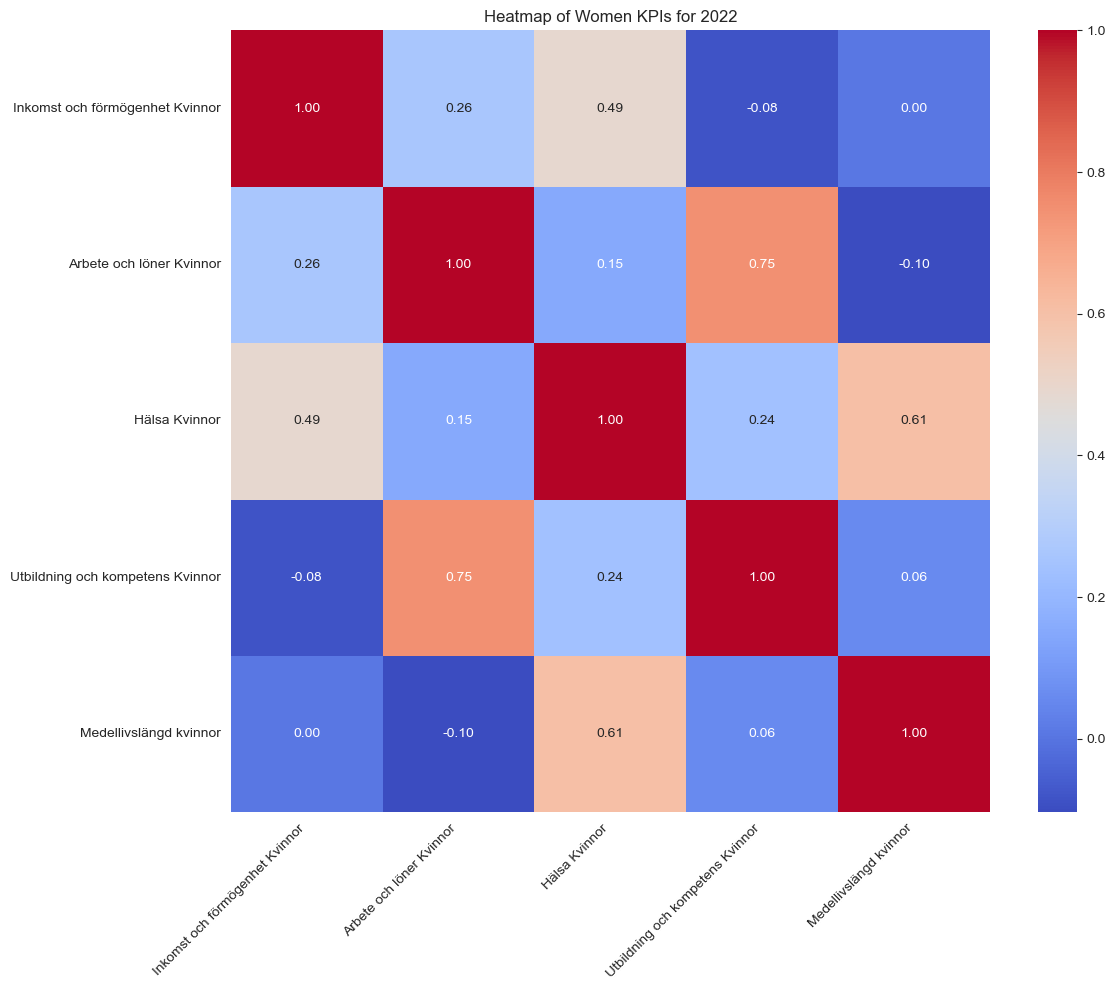

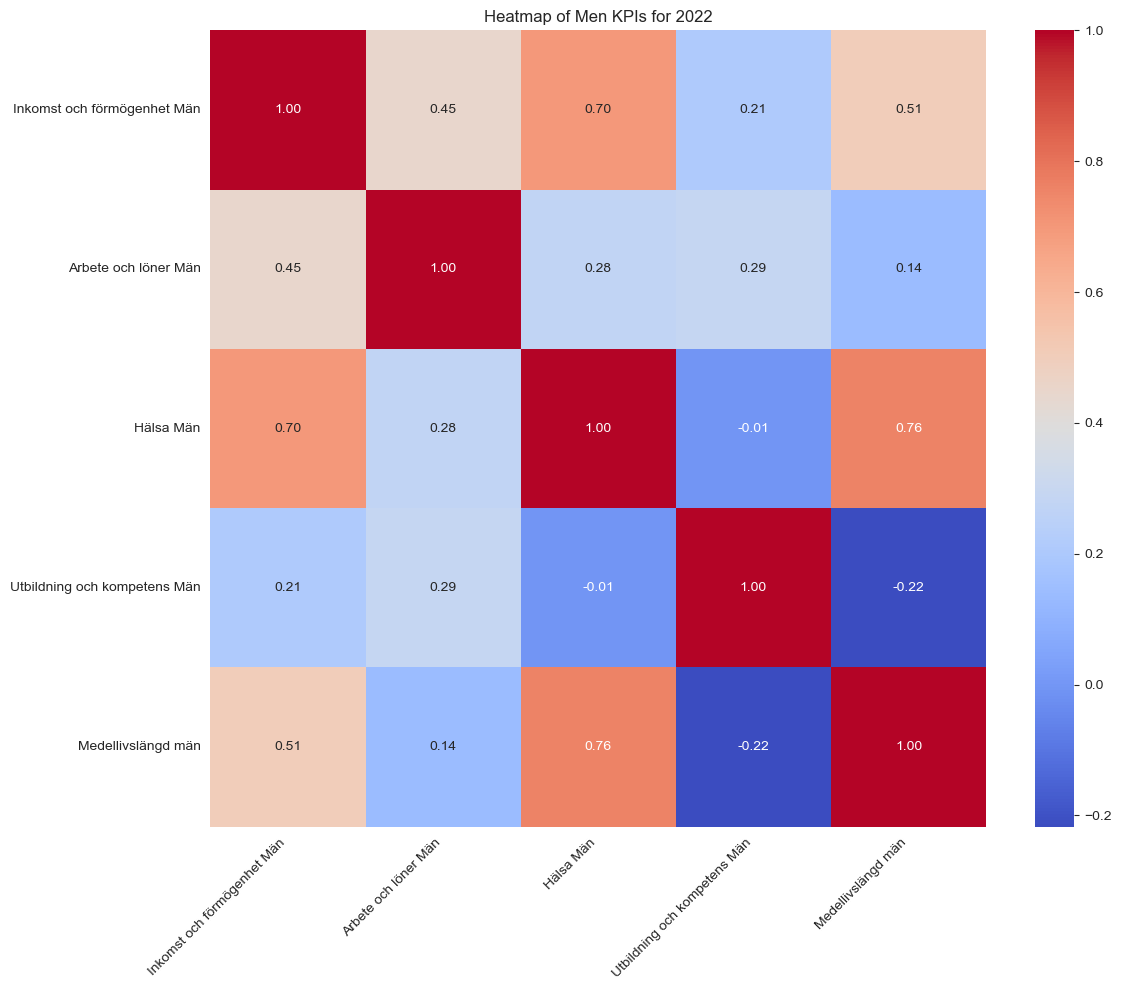

In [263]:
def create_heatmap(df, kpi_names, vars, gender):
    # Filter the DataFrame for the combined variables
    heatmap_df = df[df['kpi'].isin(vars)]

    # Pivot the DataFrame to get KPIs as columns, excluding 'municipality' from the index
    heatmap_df_pivot = heatmap_df.pivot_table(
        index='municipality',
        columns='kpi',
        values='value'
    )

    # Replace KPI IDs with names
    heatmap_df_pivot.columns = [kpi_names.get(col, col) for col in heatmap_df_pivot.columns]

    # Modify column names by removing unwanted parts of strings
    heatmap_df_pivot.columns = [col.replace(' – Regionindex', '').replace(', år', '') for col in heatmap_df_pivot.columns]

    # Calculate the correlation matrix, excluding 'municipality'
    corr_matrix = heatmap_df_pivot.corr(numeric_only=True)

    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Heatmap of {gender} KPIs for 2022')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

women_vars = independent_vars_women + dependent_vars_women
men_vars = independent_vars_men + dependent_vars_men
create_heatmap(df_2022, kpi_names, women_vars, 'Women')
create_heatmap(df_2022, kpi_names, men_vars, 'Men')

### Probability Distribution

* Use probability distributions to describe some selected variables. State why they are interesting to look at and describe your observation.
* What are the parameters in the distribution? Estimate these parameters.
* Use hypothesis testing to show some interesting conclusions.

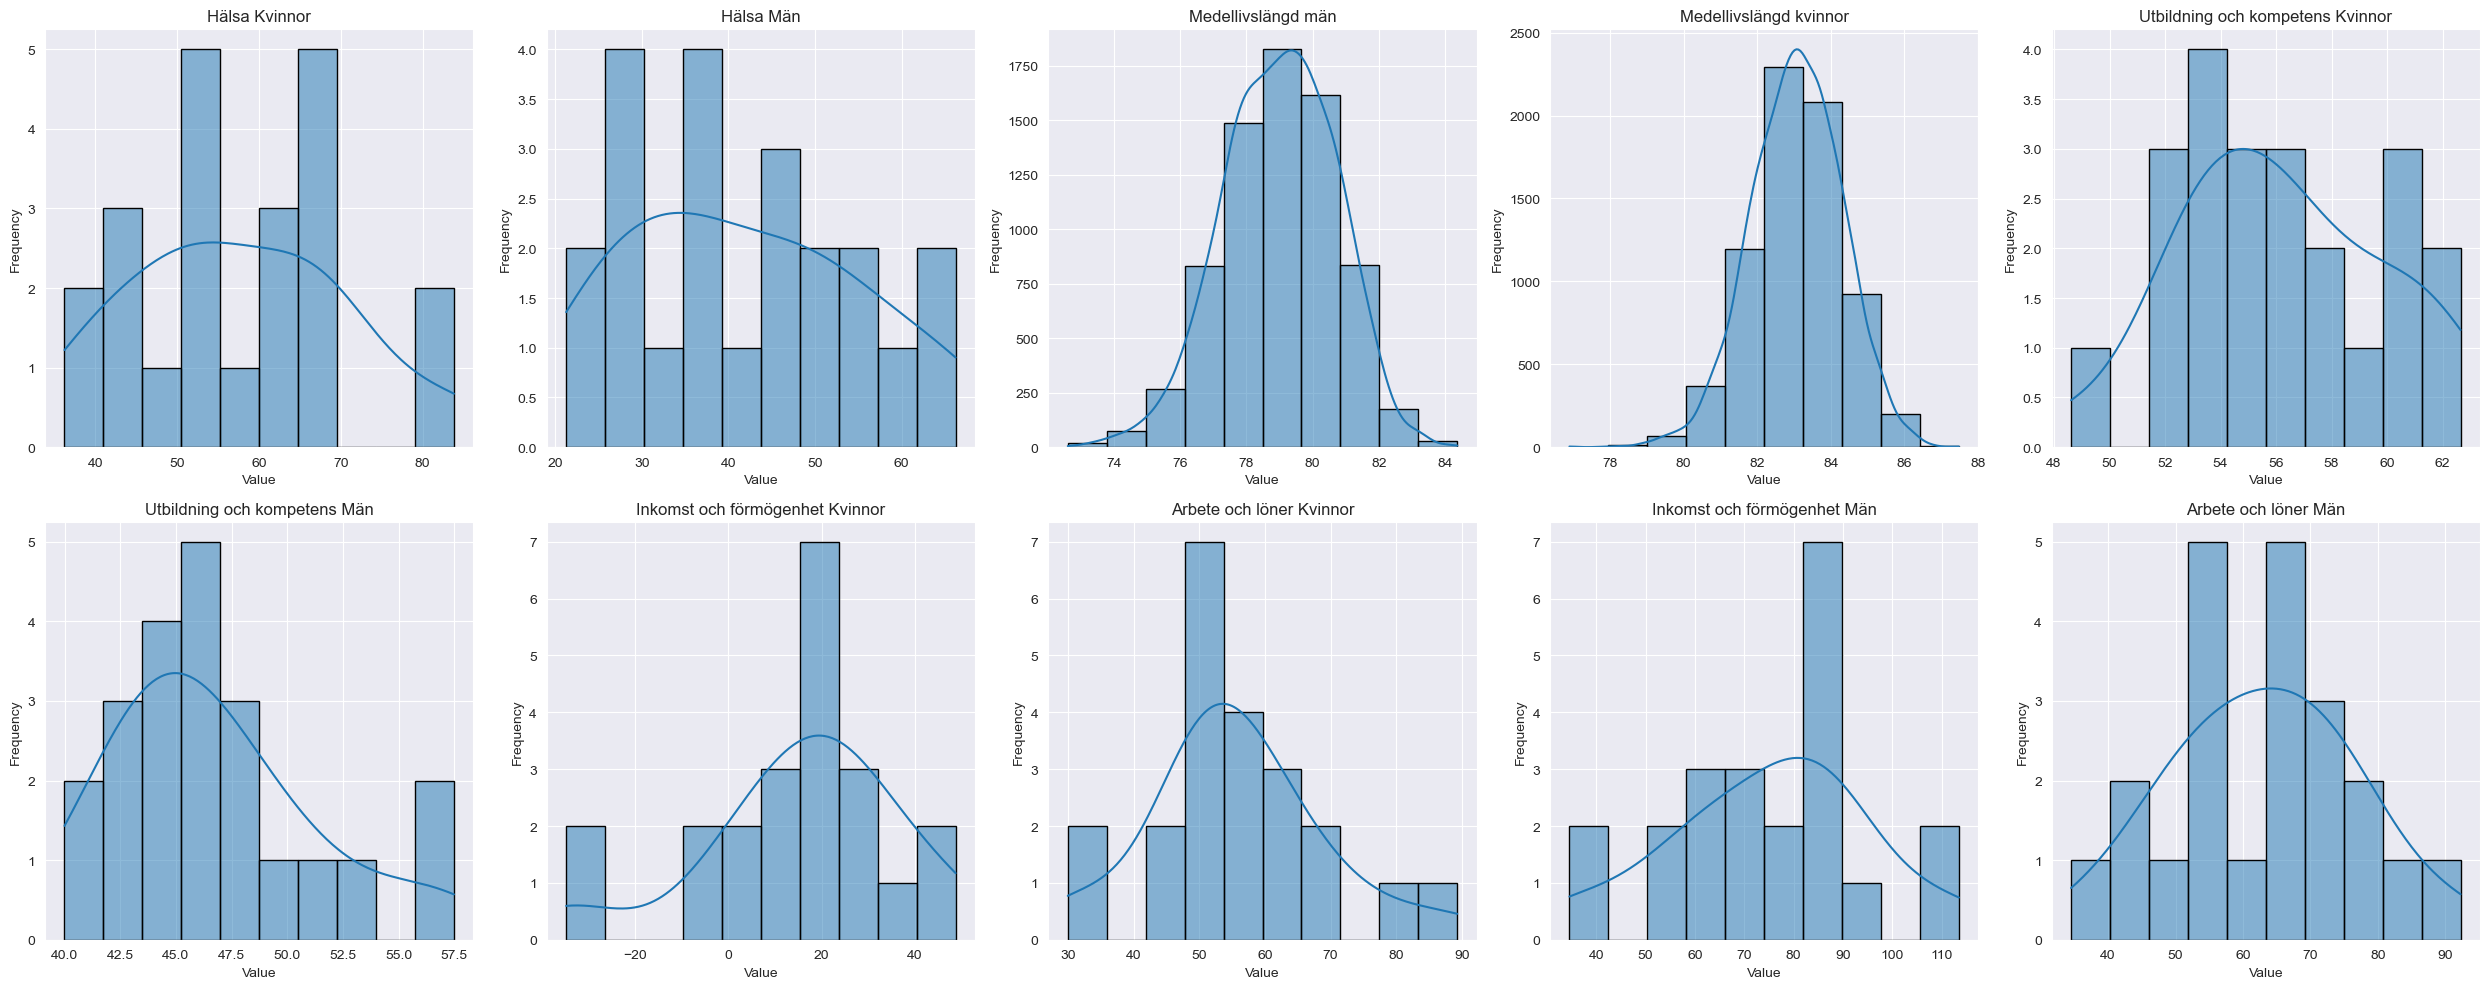

In [264]:
# Create a list with women and men variables
women_men_vars = women_vars + men_vars

# Filter Dataframe to only include the men and women kpis
women_men_df = all_kpis_df[all_kpis_df['kpi'].isin(women_men_vars)]

# Plot histograms to visualize the distributions of the variables
plot_kpi_histograms(women_men_df, kpi_names, raw_income_kpis, num_bins=10, num_cols=5)

### Probability Distribution: Observations
Based on the histograms above we will try to describe the distributions of the following variables:

1. Hälsa - Regionindex Kvinnor/Män N00351/N00362 (Health Index Women/Men): 
The histograms show a relatively symmetric distribution but with some slight deviations from the bell shape. Given this shape we believe that a normal distribution could be an approximate fit. To capture the slight skewness a more nuanced distribution is needed.
2. Inkomst och förmögenheter Kvinnor/Män (Income and Wealth Women/Men): 
These histograms show a right-skewed distribution. The distribution is not symmetric and the right tail is longer than the left tail. Given this shape we believe that a log-normal distribution could be an approximate fit.
3. Utbildning och kompetens Kvinnor/Män (Education and Competence Women/Men):
These histograms show a normal distribution as they show a bell-shaped curve which is symmetric around the mean. Given this shape we believe that a normal distribution could be an approximate fit.
4. Arbete och löner Kvinnor (Work and Salary Women): 
The histogram shows a log-normal distribution as when we apply a log transformation the distribution becomes more symmetric. Given this shape we believe that a log-normal distribution could be an approximate fit.
5. Arbete och löner Män (Work and Salary Men):
The histogram after being log-transformed shows a slight right-skewed distribution. Therefore, we can conclude that this histogram does not perfectly follow a log-normal distribution however is a reasonably close fit.

In [265]:
normal_kpis = ['N00351', 'N00925', 'N00352', 'N00348', 'N00362', 'N00923', 'N00363', 'N00359']
log_normal_kpis = ['N00349', 'N00360']

normal_params, log_normal_params = {}, {}

for kpi in normal_kpis:
    data = all_kpis_df[all_kpis_df['kpi'] == kpi]['value']
    normal_params[kpi] = {
        'mean': data.mean(),
        'std': data.std()
    }

for kpi in log_normal_kpis:
    # Ensure that data is strictly positive before log transformation
    data = all_kpis_df[all_kpis_df['kpi'] == kpi]['value']
    data = data[data > 0]

    logged_data = np.log(data)
    log_normal_params[kpi] = {
        'log_mean': logged_data.mean(),
        'log_std': logged_data.std()
    }

In [266]:
def print_parameters(params, is_log_normal=False):
    for kpi, values in params.items():
        mean_label = 'log_mean' if is_log_normal else 'mean'
        std_label = 'log_std' if is_log_normal else 'std'
        mean = round(values[mean_label], 2)
        std = round(values[std_label], 2)
        print(f"'{kpi}': Mean: {mean}, STD: {std}")

print("Normal distribution parameters:")
print_parameters(normal_params)

print("\nLog-normal distribution parameters:")
print_parameters(log_normal_params, is_log_normal=True)

Normal distribution parameters:
'N00351': Mean: 57.61, STD: 13.28
'N00925': Mean: 83.07, STD: 1.25
'N00352': Mean: 56.23, STD: 3.67
'N00348': Mean: 15.5, STD: 21.22
'N00362': Mean: 41.65, STD: 13.58
'N00923': Mean: 79.0, STD: 1.72
'N00363': Mean: 46.66, STD: 4.57
'N00359': Mean: 75.07, STD: 20.62

Log-normal distribution parameters:
'N00349': Mean: 3.99, STD: 0.25
'N00360': Mean: 4.12, STD: 0.23


### Estimation of Parameters Interpreted
#### Normal Distribution Parameters:
* `N00351`: Health Index for Women
  - Mean: 57.61
  - Standard Deviation: 13.28  
  This suggests a moderate average health index with a relatively wide-spread meaning that there is variability among women's health indices.

* `N00925`: Life Expectancy for Women
  - Mean: 83.07
  - Standard Deviation: 1.25  
  This indicates high life expectancy with low variability which shows that that life expectancy for women is quite consistent across the sample.

* `N00352`: Education and Competence for Women
  - Mean: 56.23
  - Standard Deviation: 3.67  
  A moderate average with relatively low variability representing that education and competence scores for women are quite consistent.

* `N00348`: Income and Wealth for Women
  - Mean: 15.50
  - Standard Deviation: 21.22  
  A lower average with very high variability which might suggest a wide disparity in income and wealth among women.

* `N00362`: Health Index for Men
  - Mean: 41.65
  - Standard Deviation: 13.58  
  A lower average compared to women with a wide-spread showing that there is variability among men's health indices.

* `N00923`: Life Expectancy for Men
  - Mean: 79.00
  - Standard Deviation: 1.72  
  High life expectancy with low variability which is similar to women showing a consistent life expectancy for men.

* `N00363`: Education and Competence for Men
  - Mean: 46.66
  - Standard Deviation: 4.57  
  A moderate average with relatively low variability representing that education and competence scores for men are quite consistent.

* `N00359`: Income and Wealth for Men
  - Mean: 75.07
  - Standard Deviation: 20.62  
  A higher average with high variability suggesting a wide disparity in income and wealth among men.

#### Log-normal Distribution Parameters:
* `N00349`: Work and Wages for Women (Log-transformed)
  - Log Mean: 3.99
  - Log Standard Deviation: 0.25  
  After log transformation, the mean and standard deviation suggest that the underlying distribution of logged values is moderately centered with some spread. This reflects multiplicative processes in the wages for women.

* `N00360`: Work and Wages for Men (Log-transformed)
  - Log Mean: 4.12
  - Log Standard Deviation: 0.23  
  Similar to the work and wages for women, after log transformation, the distribution of logged values appears moderately centered with low variability. This reflects multiplicative processes in the wages for men.


### Hypothesis Testing
#### Hypothesis 1_A:
* Null Hypothesis (H0_1A): There is no relationship between income and health among women.
* Alternative Hypothesis (H1_1A): There is a positive relationship between income and health among women.

#### Hypothesis 1_B:
* Null Hypothesis (H0_1B): There is no relationship between income and health among men.
* Alternative Hypothesis (H1_1B): There is a positive relationship between income and health among men.

#### Hypothesis 2_A:
* Null Hypothesis (H0_2A): There is no relationship between education and health among women.
* Alternative Hypothesis (H1_2A): There is a positive relationship between education and health among women.

#### Hypothesis 2_B:
* Null Hypothesis (H0_2B): There is no relationship between education and health among men.
* Alternative Hypothesis (H1_2B): There is a positive relationship between education and health among men.

#### Hypothesis 3_A:
* Null Hypothesis (H0_3A): The effect of income on health is greater than or equal to the effect of education on health among women.
* Alternative Hypothesis (H1_3A): The effect of education on health is greater than the effect of income on health among women.

#### Hypothesis 3_B:
* Null Hypothesis (H0_3B): The effect of income on health is greater than or equal to the effect of education on health among men.
* Alternative Hypothesis (H1_3B): The effect of education on health is greater than the effect of income on health among men.

In [267]:
# Filter the DataFrame for Health and Income KPIs by age
women_health_df = df_2022[df_2022['kpi'] == 'N00351']
women_income_df = df_2022[df_2022['kpi'] == 'N00348']
women_education_df = df_2022[df_2022['kpi'] == 'N00352']
men_health_df = df_2022[df_2022['kpi'] == 'N00362']
men_income_df = df_2022[df_2022['kpi'] == 'N00359']
men_education_df = df_2022[df_2022['kpi'] == 'N00363']

# Pivot the data
women_health_pivot = women_health_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'health'})
women_income_pivot = women_income_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'income'})
women_education_pivot = women_education_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'education'})
men_health_pivot = men_health_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'health'})
men_income_pivot = men_income_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'income'})
men_education_pivot = men_education_df.pivot_table(index=['municipality', 'gender'], values='value', aggfunc='first').rename(columns={'value': 'education'})

# Merge the pivoted data
merged_women_df = women_health_pivot.join(women_income_pivot, on=['municipality', 'gender']).join(women_education_pivot, on=['municipality', 'gender'])
merged_men_df = men_health_pivot.join(men_income_pivot, on=['municipality', 'gender']).join(men_education_pivot, on=['municipality', 'gender'])

# Determine the correlation between health and income among women
correlation_women_health_income, p_value_women_health_income = pearsonr(merged_women_df['health'], merged_women_df['income'])

# Determine the correlation between health and income among men
correlation_men_health_income, p_value_men_health_income = pearsonr(merged_men_df['health'], merged_men_df['income'])

# Determine the correlation between health and education among women
correlation_women_health_education, p_value_women_health_education = pearsonr(merged_women_df['health'], merged_women_df['education'])

# Determine the correlation between health and education among men
correlation_men_health_education, p_value_men_health_education = pearsonr(merged_men_df['health'], merged_men_df['education'])

# OLS regression to compare effects of income and education on health
model_women = smf.ols('health ~ income + education', data=merged_women_df).fit()
model_men = smf.ols('health ~ income + education', data=merged_men_df).fit()

In [268]:
# Results for Hypothesis 1A: Health and Income among women
print("Women - Health and Income Correlation")
print("Pearson correlation coefficient:", correlation_women_health_income)
print("P-value:", p_value_women_health_income)

# Results for Hypothesis 1B: Health and Income among men)
print("\nMen - Health and Income Correlation")
print("Pearson correlation coefficient:", correlation_men_health_income)
print('P-value:', p_value_men_health_income)

# Results for Hypothesis 2A: Health and Education among women
print("\nWomen - Health and Education Correlation")
print("Pearson correlation coefficient:", correlation_women_health_education)
print("P-value:", p_value_women_health_education)

# Results for Hypothesis 2B: Health and Education among men
print("\nMen - Health and Education Correlation")
print("Pearson correlation coefficient:", correlation_men_health_education)
print('P-value:', p_value_men_health_education)

Women - Health and Income Correlation
Pearson correlation coefficient: 0.4903352002041497
P-value: 0.020516279270103445

Men - Health and Income Correlation
Pearson correlation coefficient: 0.6964109636779228
P-value: 0.00031787766733710777

Women - Health and Education Correlation
Pearson correlation coefficient: 0.23814032028904936
P-value: 0.2858696864026953

Men - Health and Education Correlation
Pearson correlation coefficient: -0.0053175609276108135
P-value: 0.9812628183044294


In [269]:
# Results for Hypothesis 3A: Income vs Education on health among women
print("\nWomen - Income vs Education on health")
print(model_women.summary())

# Results for Hypothesis 3B: Income vs Education on health among men
print("\nMen - Income vs Education on health")
print(model_men.summary())


Women - Income vs Education on health
                            OLS Regression Results                            
Dep. Variable:                 health   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     4.454
Date:                Sun, 07 Jan 2024   Prob (F-statistic):             0.0259
Time:                        14:44:58   Log-Likelihood:                -83.370
No. Observations:                  22   AIC:                             172.7
Df Residuals:                      19   BIC:                             176.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

### Hypothesis Testing: Observations
#### Hypothesis 1A - Health and Income among Women:
* Results: Pearson correlation coefficient: 0.4903, P-value: 0.0205
* Conclusion: Given the p-value of 0.0205 is less than the significance level (alpha = 0.05), we reject the null hypothesis (H0_1A). This suggests there is a statistically significant positive correlation between health and income among women.

#### Hypothesis 1B - Health and Income among Men:
* Results: Pearson correlation coefficient: 0.6964, P-value: 0.0003
* Conclusion: The p-value of 0.0003 is well below the significance level, leading us to reject the null hypothesis (H0_1B). This indicates a statistically significant positive correlation between health and income among men, and the correlation appears stronger compared to women.

#### Hypothesis 2A - Health and Education among Women:
* Results: Pearson correlation coefficient: 0.2381, P-value: 0.2859
* Conclusion: The p-value of 0.2859 exceeds the alpha level of 0.05, suggesting we fail to reject the null hypothesis (H0_2A). This implies that the correlation between health and education among women is not statistically significant.

#### Hypothesis 2B - Health and Education among Men:
* Results: Pearson correlation coefficient: -0.0053, P-value: 0.9813
* Conclusion: With a p-value of 0.9813, we fail to reject the null hypothesis (H0_2B). This indicates no significant correlation between health and education among men.

#### Hypothesis 3A - Income vs Education on Health among Women:
* Results: Income Coefficient: 0.3217 (p = 0.014), Education Coefficient: 1.0193 (p = 0.155)
* Conclusion: The effect of income on health is statistically significant and positive, while the effect of education is not significant. This suggests that income has a more pronounced impact on health than education for women.

#### Hypothesis 3B - Income vs Education on Health among Men:
* Results: Income Coefficient: 0.4804 (p < 0.001), Education Coefficient: -0.4721 (p = 0.346)
* Conclusion: Income shows a significant positive effect on health whereas education does not show a significant effect and tends to have a negative coefficient. This implies that for men income has a greater effect on health compared to education.

### Predictive Analysis

* Apply two predictive machine learning models to solve your problem. You can use anything from scikit learn or other libraries.
* Evaluate their performance. Which one do you prefer and why? Conduct hypothesis testing to answer this question.

In [270]:
def run_regression_model(df, dependent_kpi, independent_kpis):
    # Pivot the data to get KPIs as columns
    df_pivot = df.pivot_table(index='municipality', columns='kpi', values='value')

    # Fill NaN values with the mean of each column
    df_pivot_filled = df_pivot.fillna(df_pivot.mean())

    # Define the independent variables
    X = df_pivot_filled[independent_kpis]

    # Define the dependent variable
    y = df_pivot_filled[dependent_kpi]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Add a constant to the model (for the intercept)
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)

    # Create and train the linear regression model using statsmodels
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Get predictions
    y_pred = model.predict(X_test_with_const)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    # Output the model's summary and MSE
    print(f"Model Summary for Dependent KPI: {dependent_kpi}")
    print(model.summary())
    print("\nMean Squared Error:", mse)

In [271]:
# Filter the data to only include the regional municipalities
regional_df = df_2022[df_2022['municipality'].isin(range(26))]

# Independent KPIs including confounding variables
independent_women_kpis = ['N00352', 'N00348', 'N00349', 'U01402', 'U01405', 'U01411']
independent_men_kpis = ['N00363', 'N00359', 'N00360', 'U01402', 'U01405', 'U01411']

# Run the regression model for Health Index for Women
run_regression_model(regional_df, 'N00351', independent_women_kpis)

# Run the regression model for Life Expectancy for Women
run_regression_model(regional_df, 'N00925', independent_women_kpis)

# Run the regression model for Health Index for Men
run_regression_model(regional_df, 'N00362', independent_men_kpis)

# Run the regression model for Life Expectancy for Men
run_regression_model(regional_df, 'N00923', independent_men_kpis)

Model Summary for Dependent KPI: N00351
                            OLS Regression Results                            
Dep. Variable:                 N00351   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     19.02
Date:                Sun, 07 Jan 2024   Prob (F-statistic):           6.21e-05
Time:                        14:44:58   Log-Likelihood:                -44.514
No. Observations:                  17   AIC:                             103.0
Df Residuals:                      10   BIC:                             108.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\nilsd\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Model Summary for Dependent KPI: N00925
                            OLS Regression Results                            
Dep. Variable:                 N00925   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     3.241
Date:                Sun, 07 Jan 2024   Prob (F-statistic):             0.0490
Time:                        14:44:58   Log-Likelihood:                -5.2079
No. Observations:                  17   AIC:                             24.42
Df Residuals:                      10   BIC:                             30.25
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [272]:
# Nearest Neighbors Regression Model
def run_knn_model(df, dependent_kpi, independent_kpis, n_neighbors=5):
    # Pivot the data to get KPIs as columns
    df_pivot = df.pivot_table(index='municipality', columns='kpi', values='value')

    # Fill NaN values with the mean of each column
    df_pivot_filled = df_pivot.fillna(df_pivot.mean())

    # Define the independent variables
    X = df_pivot_filled[independent_kpis]

    # Define the dependent variable
    y = df_pivot_filled[dependent_kpi]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the K-Nearest Neighbors model
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Get predictions
    y_pred = knn_model.predict(X_test)

    # Calculate Mean Squared Error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Output the model's MSE and R-squared
    print(f"K-Nearest Neighbors Model Summary for Dependent KPI: {dependent_kpi}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}\n")

In [273]:
run_knn_model(regional_df, 'N00351', independent_women_kpis)  # For women's health index
run_knn_model(regional_df, 'N00925', independent_women_kpis)  # For women's life expectancy
run_knn_model(regional_df, 'N00362', independent_men_kpis) # For men's health index
run_knn_model(regional_df, 'N00923', independent_men_kpis) # For men's life expectancy

K-Nearest Neighbors Model Summary for Dependent KPI: N00351
Mean Squared Error: 226.1529985369741
R-squared: 0.17177812356203925

K-Nearest Neighbors Model Summary for Dependent KPI: N00925
Mean Squared Error: 0.2382384000000029
R-squared: -0.6695520547177083

K-Nearest Neighbors Model Summary for Dependent KPI: N00362
Mean Squared Error: 155.14669701800608
R-squared: 0.25981378162053936

K-Nearest Neighbors Model Summary for Dependent KPI: N00923
Mean Squared Error: 0.0820392000000045
R-squared: 0.26698355968545595


### Hypothesis Testing for Predictive Models

#### Hypothesis 1 - Predictive model comparison
* Null Hypothesis (H0_1): There is no difference in performance between the linear regression and K-Nearest Neighbors models.
* Alternative Hypothesis (H1_1): There is a difference in performance between the linear regression and K-Nearest Neighbors models.

In [274]:
def compare_model_performance(df, dependent_kpi, independent_kpis, n_neighbors=5, cv_folds=10):
    # Pivot the data to get KPIs as columns
    df_pivot = df.pivot_table(index='municipality', columns='kpi', values='value')
    
    # Fill NaN values with the mean of each column
    df_pivot_filled = df_pivot.fillna(df_pivot.mean())
    
    # Define the independent variables
    X = df_pivot_filled[independent_kpis]
    
    # Define the dependent variable
    y = df_pivot_filled[dependent_kpi]

    # Define the models
    model_lr = LinearRegression()
    model_knn = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Perform cross-validation
    scores_lr = cross_val_score(model_lr, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    scores_knn = cross_val_score(model_knn, X, y, cv=cv_folds, scoring='neg_mean_squared_error')

    # Convert scores to positive MSE
    scores_lr = -scores_lr
    scores_knn = -scores_knn

    # Perform paired t-test
    t_statistic, p_value = ttest_rel(scores_lr, scores_knn)

    # Output the results
    print(f"Linear Regression vs K-Nearest Neighbors Model Comparison:")
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis - Significant difference in model performance\n")
    else:
        print(f"Fail to reject the null hypothesis - No significant difference in model performance\n")

In [275]:
# Run the comparison for Health Index for Women
compare_model_performance(regional_df, 'N00351', independent_women_kpis)

# Run the comparison for Life Expectancy for Women
compare_model_performance(regional_df, 'N00925', independent_women_kpis)

# Run the comparison for Health Index for Men
compare_model_performance(regional_df, 'N00362', independent_men_kpis)

# Run the comparison for Life Expectancy for Men
compare_model_performance(regional_df, 'N00923', independent_men_kpis)

Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -3.4377439434849366, P-value: 0.007416904666533441
Reject the null hypothesis - Significant difference in model performance

Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -2.327399404637589, P-value: 0.044938081705504236
Reject the null hypothesis - Significant difference in model performance
Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -2.9123270469994393, P-value: 0.017245809093807272
Reject the null hypothesis - Significant difference in model performance

Linear Regression vs K-Nearest Neighbors Model Comparison:
T-statistic: -1.182471839219318, P-value: 0.26731524828605707
Fail to reject the null hypothesis - No significant difference in model performance


### Predictive Analysis: Observations
#### Linear Regression Model Results:
1. Health Index for Women (N00351):
    - Mean Squared Error: 30.68
    - R-squared: 0.887
2. Life Expectancy for Women (N00925):
    - Mean Squared Error: 0.075
    - R-squared: 0.474
3. Health Index for Men (N00362):
    - Mean Squared Error: 57.87
    - R-squared: 0.724
4. Life Expectancy for Men (N00923):
    - Mean Squared Error: 0.354
    - R-squared: 0.770

#### K-Nearest Neighbors Model Results:
1. Health Index for Women (N00351):
    - Mean Squared Error: 226.15
    - R-squared: 0.172
2. Life Expectancy for Women (N00925):
    - Mean Squared Error: 0.238
    - R-squared: -0.670
3. Health Index for Men (N00362):
    - Mean Squared Error: 155.15
    - R-squared: 0.260
4. Life Expectancy for Men (N00923):
    - Mean Squared Error: 0.082
    - R-squared: 0.267

#### Hypothesis 1 - Predictive model comparison:
* **Model Performance (MSE and R-squared):** The linear regression model consistently shows lower MSE values and higher R-squared values across all dependent KPIs showing a better predictive accuracy and model fit compared to the nearest neighbor model.
* **Hypothesis Testing Results:** The hypothesis testing results (T-statistic and P-value) demonstrate a significant difference in model performance in favor of the linear regression model for three of the four KPIs. Only in the case of Life Expectancy for Men (N00923) was there no significant difference found.

### Conclusion

* State again your problem and the motivation.
* Draw a final conclusion.
* If you keep working on this project, what would be the next step?   

### References:
- Silhouette (clustering) (2023). Available at: https://en.wikipedia.org/wiki/Silhouette_%28clustering%29 (Accessed: 10 December 2023).